# Introduction to Gaussian Processes

## Overview and Definition
Week 7 materials are [here](https://drive.google.com/drive/folders/1mu5sFf0MPF0XCMoirZ4TFHR-D7CtaohA?usp=sharing)

In week 7, we will dive into Gaussian Processes in a greater detail. From previous weeks, we know that machine learning often focuses on extracting numerous, complex parameters from data, like neural network weights, which can be hard to interpret. Gaussian processes differ by allowing us to directly consider the broad characteristics of potential functions fitting our data, such as their variability, periodicity, or other structural features. They enable the incorporation of these insights into our models by defining a Gaussian distribution over the functions that best match our observations. Essentially, a Gaussian Process is a collection of random variables, any finite number of which have a joint Gaussian distribution. This makes GPs a natural choice for modeling distributions over functions. They are particularly powerful for regression problems, where the goal is to predict continuous outcomes.


## Some intuitive examples {cite}`zhang2023dive`
In the given dataset, we have a series of regression targets, denoted as $y$, which are associated with their corresponding inputs, $x$.

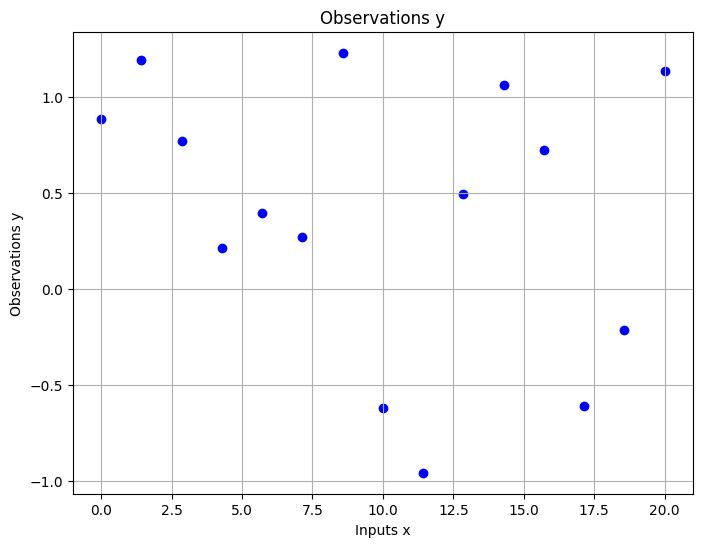

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Generating sample data
np.random.seed(0)  # For reproducibility
x = np.linspace(0, 20, 15)  # 15 data points between 0 and 20
y = np.sin(x) + np.random.normal(scale=0.5, size=x.shape)  # Observations with noise

# Plotting the data
plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(x, y, color='blue')  # Scatter plot of observations
plt.title('Observations y')  
plt.xlabel('Inputs x') 
plt.ylabel('Observations y') 
plt.grid(True)  # Adding a grid for better readability
plt.show()  # Display the plot



To model our data using a Gaussian process, we first establish a prior reflecting plausible function behaviors, like their variation with respect to the inputs. The samples displayed here illustrate this prior. 

In [ ]:
pip install GPy

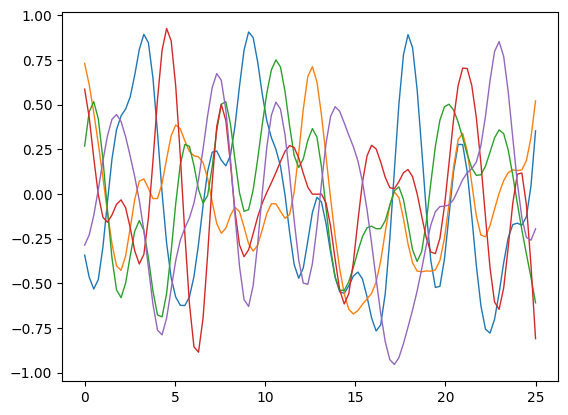

In [15]:
import GPy
import numpy as np
import matplotlib.pyplot as plt

# Define the kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

# Define the range of the input space
X = np.linspace(0, 25, 100).reshape(-1, 1)

# Create a Gaussian process regression model
gp = GPy.models.GPRegression(X, np.zeros((100, 1)), kernel)

# Sample functions from the Gaussian process
num_samples = 5
Y_samples = gp.posterior_samples_f(X, size=num_samples)

# Plot the sampled functions
for i in range(num_samples):
    plt.plot(X, Y_samples[:, :, i], lw=1)

# Display the plot
plt.show()


Now we've conditioned on the data, we can use prior to infer about the posterior distribution over functions.

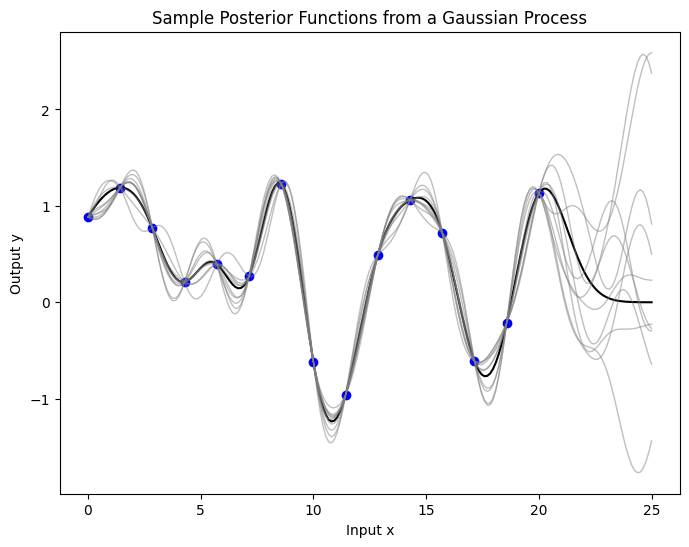

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

# Set the random seed for reproducibility
np.random.seed(0)

# Generating sample data
x = np.linspace(0, 20, 15)  # 15 data points between 0 and 20
y = np.sin(x) + np.random.normal(scale=0.5, size=x.shape)  # Observations with noise

# Reshape x and y for GPy requirements
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Define the kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=2.)

# Create a GP model
gp_model = GPy.models.GPRegression(x, y, kernel)

# Optimise the model
gp_model.optimize(messages=True)

# Predicting on a dense set of points to get smooth sample functions
x_pred = np.linspace(0, 25, 200).reshape(-1, 1)
y_pred, y_var = gp_model.predict(x_pred)
y_pred = y_pred.reshape(-1)

# Draw samples from the posterior
num_samples = 10
samples = gp_model.posterior_samples_f(x_pred, full_cov=True, size=num_samples)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Observed Data')
plt.plot(x_pred, y_pred, color='black', label='Mean Prediction')
for i in range(num_samples):
    plt.plot(x_pred, samples[:, :, i], color='gray', lw=1, alpha=0.5)
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.title('Sample Posterior Functions from a Gaussian Process')

plt.show()



The plot below illustrates the epistemic uncertainty in our predictions, showing where there's more potential variability in the underlying true function. This type of uncertainty decreases as we gather more data. The shaded area represents a 95% credible interval around the mean prediction, calculated as twice the posterior standard deviation, indicating where the true function values likely fall for any input $x$.

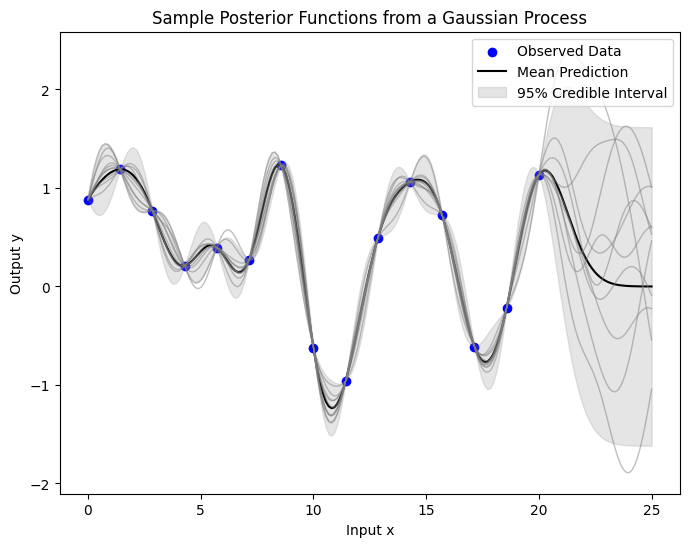

In [24]:
# Predicting on a dense set of points to get smooth sample functions
x_pred = np.linspace(0, 25, 200).reshape(-1, 1)
y_pred, y_var = gp_model.predict(x_pred)
y_pred = y_pred.reshape(-1)
y_std = np.sqrt(y_var).reshape(-1)

# Draw samples from the posterior
num_samples = 10
samples = gp_model.posterior_samples_f(x_pred, full_cov=True, size=num_samples)

# Plot the mean prediction with the observed data
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Observed Data')
plt.plot(x_pred, y_pred, color='black', label='Mean Prediction')

# Plot the uncertainty (95% credible interval)
plt.fill_between(x_pred.flatten(), 
                 (y_pred - 1.96 * y_std).flatten(), 
                 (y_pred + 1.96 * y_std).flatten(), 
                 color='gray', alpha=0.2, label='95% Credible Interval')

# Plot the samples from the posterior
for i in range(num_samples):
    plt.plot(x_pred, samples[:, :, i], color='gray', lw=1, alpha=0.5)

plt.xlabel('Input x')
plt.ylabel('Output y')
plt.title('Sample Posterior Functions from a Gaussian Process')
plt.legend(loc='upper right')

plt.show()


Now, you should get some ideas of how GP works roughly, from the prior to the posterior distributions over the functions.



## Mathematical Framework {cite}`zhang2023dive,bishop2006pattern`

### Basic Concepts
A Gaussian Process (GP) is essentially an advanced form of a Gaussian (or normal) distribution, but instead of being over simple variables, it's over functions. Imagine a GP as a method to predict or estimate a function based on known data points. 

In mathematical terms, a GP is defined for a set of function values, where these values follow a Gaussian distribution. Specifically, for any selection of points from a set $X$, the values that a function $f$ takes at these points follow a joint Gaussian distribution.

The key to understanding GPs lies in two main concepts:
1. **Mean Function**: $m: X \rightarrow Y$. This function gives the average expected value of the function $f(x)$ at each point $x$ in the set $X$. It's like predicting the average outcome based on the known data.
2. **Kernel or Covariance Function**: $k: X \times X \rightarrow Y$. This function tells us how much two points in the set $X$ are related or how they influence each other. It's a way of understanding the relationship or similarity between different points in our data.

To apply GPs in a practical setting, we typically select several points in our input space $X$, calculate the mean and covariance at these points, and then use this information to make predictions. This process involves working with vectors and matrices derived from the mean and kernel functions to graphically represent the Gaussian Process.

**Note**: In mathematical notation, for a set of points $ \mathbf{X}=x_1, \ldots, x_N $, the mean vector $ \mathbf{m} $ and covariance matrix $ \mathbf{K} $ are constructed from these points using the mean and kernel functions. Each element of $ \mathbf{m} $ and $ \mathbf{K} $ corresponds to the mean and covariance values calculated for these points.
### Covariance Functions (Kernels)
Covariance functions, or kernels, determine how a Gaussian Process (GP) generalizes from observed data. They are fundamental in defining the GP's behavior.

- **Concept and Mathematical Representation**:
  - Kernels measure the similarity between points in input space. The function $k(x, x')$ computes the covariance between the outputs corresponding to inputs $x$ and $x'$.
  - For example, the Radial Basis Function (RBF) kernel is defined as $k(x, x') = \exp\left(-\frac{1}{2l^2} \| x - x' \|^2\right)$, where $l$ is the length-scale parameter.

- **Types of Kernels and Their Uses**:
  - **RBF Kernel**: Suited for smooth functions. The length-scale $l$ controls how rapidly the correlation decreases with distance.
  - **Linear Kernel**: $k(x, x') = x^T x'$, useful for linear relationships.
  - **Periodic Kernels**: Capture periodic behavior, expressed as $k(x, x') = \exp\left(-\frac{2\sin^2(\pi|x - x'|)}{l^2}\right)$.
  
  
  In our context, the **RBF Kernel** will be used in most cases. More practical examples are in future chapters. 

- **Hyperparameter Tuning**:
  - Hyperparameters like $l$ in RBF or periodicity in periodic kernels crucially affect GP modeling. Their tuning, often through methods like maximum likelihood, adapts the GP to the specific data structure.

- **Choosing the Right Kernel**:
  - Involves understanding data characteristics. RBF is a default choice for many, but specific data patterns might necessitate different or combined kernels.



### Mean and Variance
The mean and variance functions in a Gaussian Process (GP) provide predictions and their uncertainties.

- **Mean Function - Mathematical Explanation**:
  - The mean function, often denoted as $m(x)$, gives the expected value of the function at each point. A common assumption is $m(x) = 0$, although non-zero means can incorporate prior trends. 

- **Variance Function - Quantifying Uncertainty**:
  - The variance, denoted as $\sigma^2(x)$, represents the uncertainty in predictions. It's calculated as $\sigma^2(x) = k(x, x) - K(X, x)^T[K(X, X) + \sigma^2_nI]^{-1}K(X, x)$, where $K(X, x)$ and $K(X, X)$ are covariance matrices, and $\sigma^2_n$ is the noise term.

- **Practical Interpretation**:
  - High variance at a point suggests low confidence in predictions there, guiding decisions on where more data might be needed or caution in using the predictions.

- **Mean and Variance in Predictions**:
  - Together, they provide a probabilistic forecast. The mean offers the best guess, while the variance indicates reliability. This duo is key in risk-sensitive applications.


## Gaussian Process - A Logical Processing Chain

Just like other machine learning algorithm, the logical processing chain for a Gaussian Process (GP) involves thoese key steps:

1. **Defining the Problem**:
   - Start by identifying the problem to be solved using GP, such as regression, classification, or another task where predicting a continuous function is required.

2. **Data Preparation**:
   - Organise the data into a suitable format. This includes input features and corresponding target values.

3. **Choosing a Kernel Function**:
   - Select an appropriate kernel (covariance function) for the GP. The choice depends on the nature of the data and the problem.

4. **Setting the Hyperparameters**:
   - Initialise hyperparameters for the chosen kernel. These can include parameters like length-scale in the RBF kernel or periodicity in a periodic kernel.

5. **Model Training**:
   - Train the GP model by optimizing the hyperparameters. This usually involves maximizing the likelihood of the observed data under the GP model.

6. **Prediction**:
   - Use the trained GP model to make predictions. This involves computing the mean and variance of the GP’s posterior distribution.

7. **Model Evaluation**:
   - Evaluate the model's performance using suitable metrics. For regression, this could be RMSE or MAE; for classification, accuracy or AUC.

8. **Refinement**:
   - Based on the evaluation, refine the model by adjusting hyperparameters or kernel choice, and retrain if necessary.

This chain provides a comprehensive overview of the steps involved in applying Gaussian Processes to a problem, from initial setup to prediction and evaluation.

With a foundational understanding of Gaussian Processes (GP) established, we are now ready to delve deeper into the subject. Let's now dive into details by following notebooks:

- [Introduction to Gaussian Processes](https://colab.research.google.com/github/d2l-ai/d2l-pytorch-colab/blob/master/chapter_gaussian-processes/gp-intro.ipynb)
- [Gaussian Process Priors](https://colab.research.google.com/github/d2l-ai/d2l-pytorch-colab/blob/master/chapter_gaussian-processes/gp-priors.ipynb)
- [Gaussian Process Inference](https://colab.research.google.com/github/d2l-ai/d2l-pytorch-colab/blob/master/chapter_gaussian-processes/gp-inference.ipynb)
- [GPSat: GP Regression](https://colab.research.google.com/github/CPOMUCL/GPSat/blob/main/docs/notebooks/gp_regression.ipynb)
- [GPSat: Using GPUs](https://colab.research.google.com/github/CPOMUCL/GPSat/blob/main/docs/notebooks/using_gpus.ipynb)
- [GPSat: 1-D Local Expert Model Part-1](https://colab.research.google.com/github/CPOMUCL/GPSat/blob/main/docs/notebooks/1d_local_expert_model_part_1.ipynb)
- [GPSat: 1-D Local Expert Model Part-2](https://colab.research.google.com/github/CPOMUCL/GPSat/blob/main/docs/notebooks/1d_local_expert_model_part_2.ipynb)
- [GPSat: Inline Example](https://colab.research.google.com/github/CPOMUCL/GPSat/blob/main/docs/notebooks/inline_example.ipynb)


Before running any of the GPSat notebook above, please run the following cells to install GPSat package.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# TODO: allow for mounting of gdrive
# TODO: allow for checking out a branch

if IN_COLAB:
    
    import os
    import re

    # change to working directory
    work_dir = "/content"
    
    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)
    
    # clone repository
    !git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)

In [ ]:
if IN_COLAB:
    !pip install -r requirements.txt

In [ ]:
if IN_COLAB:
    !pip install -e .